<a href="https://colab.research.google.com/github/Thush099/CM2604-Churn-Classifier/blob/main/CM2604_Telco_Churn_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn — Notebook
Author: Thushanth Mahendran
Course: CM2604 Machine Learning


####Load libraries and set plotting style.

In [30]:
# 1. IMPORTS & SETTINGS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io, os
from google.colab import files

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, auc
)
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={"figure.figsize": (8,5)})

print("Libraries loaded. TensorFlow version:", tf.__version__)

Libraries loaded. TensorFlow version: 2.19.0


####Upload Data set

In [31]:
# 2. LOAD CSV FROM COLAB FILE DIRECTORY

import pandas as pd

csv_path = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(csv_path)

print("Dataset loaded from:", csv_path)
print("Shape (rows, columns):", df.shape)

print("\nFirst three rows:")
display(df.head(3))

print("\nColumn dtypes summary:")
print(df.dtypes.value_counts())

Dataset loaded from: /content/WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape (rows, columns): (7043, 21)

First three rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes



Column dtypes summary:
object     18
int64       2
float64     1
Name: count, dtype: int64


### Inspect dataset structure
Check columns, datatypes and missing values so we know what cleaning is needed.

In [32]:
# 3 - inspect columns/dtypes/missing
print("Shape (rows, cols):", df.shape)
print("\nColumns list:")
print(df.columns.tolist())

print("\nDtypes summary:")
print(df.dtypes)

print("\nMissing values (sorted):")
print(df.isna().sum().sort_values(ascending=False).head(20))

Shape (rows, cols): (7043, 21)

Columns list:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Dtypes summary:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing va

### Quick sanity checks
Look for duplicates and unusual values in ID or TotalCharges.

In [33]:
# 4 - sanity checks
# If customerID exists, check duplicates
if 'customerID' in df.columns:
    print("customerID duplicates:", df['customerID'].duplicated().sum())

# Check a few samples from TotalCharges to see formatting
if 'TotalCharges' in df.columns:
    print("\nTotalCharges sample values:")
    print(df['TotalCharges'].sample(8).values)

customerID duplicates: 0

TotalCharges sample values:
['507.4' '299.4' '5760.65' '1048.85' '1025.15' '6876.05' '6435.25'
 '4146.05']


### Cleaning: convert TotalCharges to numeric and remove identifier
Convert TotalCharges to numeric (coerce invalid → NaN) and drop very few NaN rows.
Also drop customerID (identifier).

In [34]:
# 5 - clean TotalCharges and drop ID
if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == 'object':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    print("TotalCharges NaNs after coercion:", df['TotalCharges'].isna().sum())

# If only a tiny fraction missing, drop them and report
if 'TotalCharges' in df.columns:
    n_missing = df['TotalCharges'].isna().sum()
    if n_missing > 0 and n_missing / len(df) < 0.01:
        df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
        print("Dropped rows with missing TotalCharges. New shape:", df.shape)
    elif n_missing > 0:
        print("Warning: several TotalCharges missing; consider imputation instead of dropping.")

# Drop ID column if present
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
    print("Dropped customerID column. Shape now:", df.shape)


TotalCharges NaNs after coercion: 11
Dropped rows with missing TotalCharges. New shape: (7032, 21)
Dropped customerID column. Shape now: (7032, 20)


### Encode target and identify feature types
Encode Churn to 0/1 and show which columns are numeric and which are categorical.

In [35]:
# 6 - target encoding and feature lists
if 'Churn' not in df.columns:
    raise ValueError("No 'Churn' column found — check dataset.")
df['Churn'] = df['Churn'].map({'No':0, 'Yes':1})

# Detect numeric and categorical
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if 'Churn' in numeric_cols:
    numeric_cols.remove('Churn')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns (count):", len(numeric_cols))
print(numeric_cols)
print("\nCategorical columns (count):", len(categorical_cols))
print(categorical_cols)
print("\nChurn distribution (proportion):")
print(df['Churn'].value_counts(normalize=True).round(3))

Numeric columns (count): 4
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Categorical columns (count): 15
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Churn distribution (proportion):
Churn
0    0.734
1    0.266
Name: proportion, dtype: float64


### EDA: class balance and some feature relationships
Plot churn counts and a couple of numeric feature comparisons.

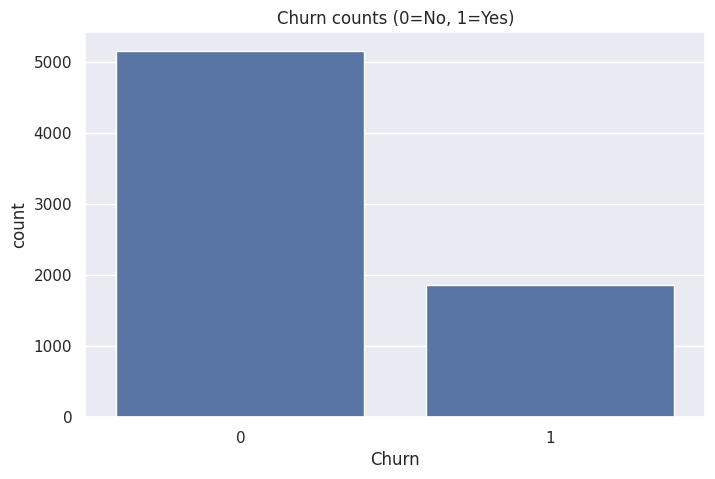

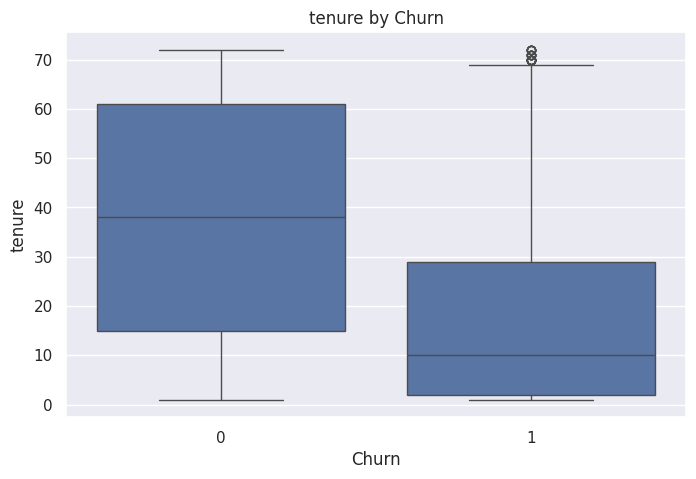

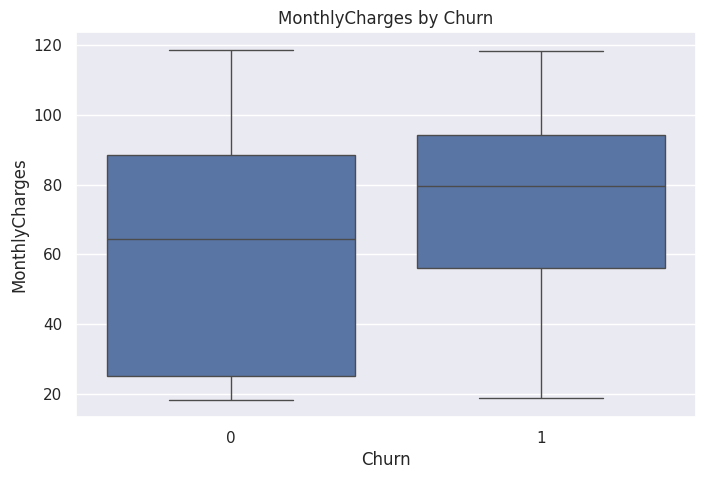

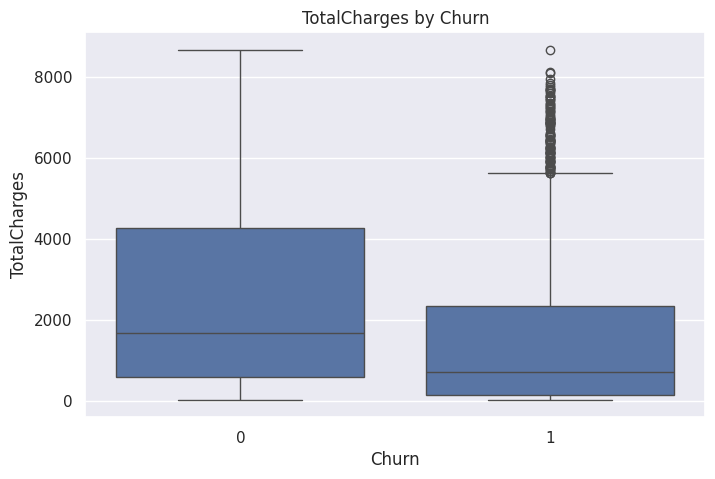

In [36]:
# 7 - EDA plots (run one by one if needed)
import matplotlib.pyplot as plt
import seaborn as sns

# Churn counts
plt.figure()
sns.countplot(data=df, x='Churn')
plt.title('Churn counts (0=No, 1=Yes)')
plt.show()

# Tenure, MonthlyCharges, TotalCharges if present
for col in ['tenure','MonthlyCharges','TotalCharges']:
    if col in df.columns:
        plt.figure()
        sns.boxplot(data=df, x='Churn', y=col)
        plt.title(f'{col} by Churn')
        plt.show()

EDA: churn distribution and numeric feature comparisons (boxplots)

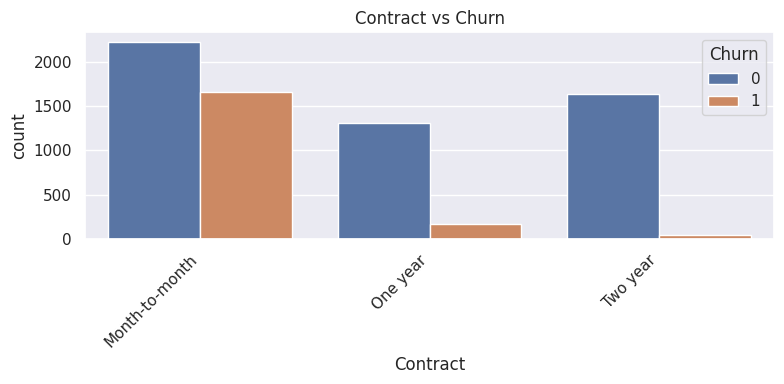

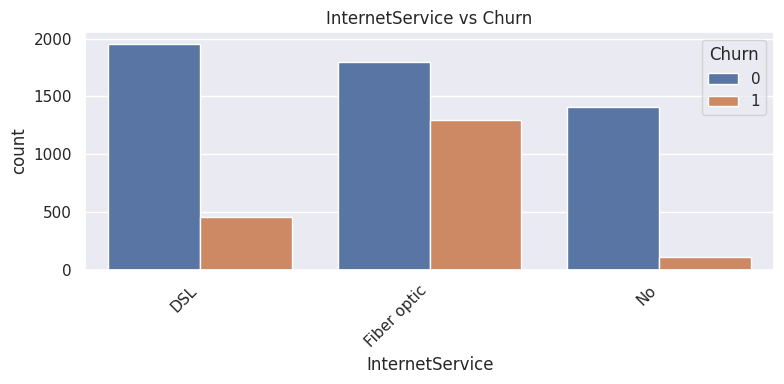

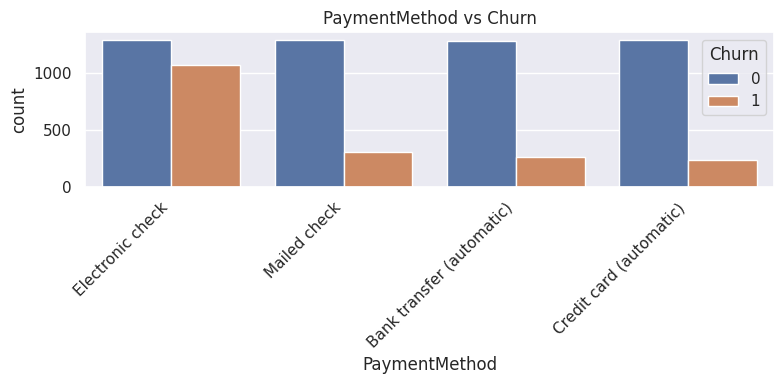

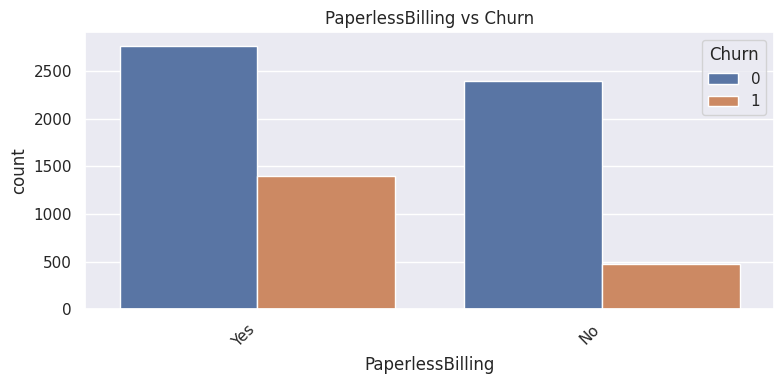

In [37]:
# 8 - categorical vs churn
plot_cols = ['Contract','InternetService','PaymentMethod','PaperlessBilling']
for c in plot_cols:
    if c in df.columns:
        plt.figure(figsize=(8,4))
        sns.countplot(data=df, x=c, hue='Churn')
        plt.title(f'{c} vs Churn')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

### Train/test split
Create stratified train/test split (80/20) so class proportions are preserved in both sets.

In [38]:
# 9 - train/test split
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train churn rate:", y_train.mean(), "Test churn rate:", y_test.mean())

Train shape: (5625, 19)
Test shape: (1407, 19)
Train churn rate: 0.2657777777777778 Test churn rate: 0.2658137882018479


### Preprocessing pipeline
Build ColumnTransformer: median imputation + scaling for numeric, most_frequent + one-hot for categorical.

In [39]:
# 10 - preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# if SeniorCitizen shows up as object, convert it
if 'SeniorCitizen' in X_train.columns and X_train['SeniorCitizen'].dtype == 'object':
    X_train['SeniorCitizen'] = X_train['SeniorCitizen'].astype(int)
    X_test['SeniorCitizen'] = X_test['SeniorCitizen'].astype(int)
    if 'SeniorCitizen' in categorical_cols:
        categorical_cols.remove('SeniorCitizen')
        numeric_cols.append('SeniorCitizen')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, [c for c in numeric_cols if c in X_train.columns]),
    ('cat', categorical_transformer, [c for c in categorical_cols if c in X_train.columns])
], remainder='drop')

# Fit preprocessor on training data to inspect how many output features we get
preprocessor.fit(X_train)
try:
    n_cat_feats = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out().shape[0]
except Exception:
    n_cat_feats = 0
n_num = len([c for c in numeric_cols if c in X_train.columns])
print("Numeric features:", n_num, "One-hot features:", n_cat_feats, "Total:", n_num + n_cat_feats)

Numeric features: 4 One-hot features: 41 Total: 45


# Task 2 — Model building & experiments: Decision Tree baseline


####Train a Decision Tree classifier using the preprocessing pipeline and report baseline metrics (accuracy, precision, recall, F1, AUC).

In [40]:
# Decision Tree baseline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

# Create pipeline: reuse preprocessor you fitted earlier
dt_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

# Fit baseline
dt_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_pipeline.predict(X_test)
# Probabilities for AUC
y_proba_dt = dt_pipeline.predict_proba(X_test)[:,1] if hasattr(dt_pipeline.named_steps['clf'], "predict_proba") else None

# Compute metrics
dt_acc = accuracy_score(y_test, y_pred_dt)
dt_prec = precision_score(y_test, y_pred_dt, zero_division=0)
dt_rec = recall_score(y_test, y_pred_dt, zero_division=0)
dt_f1 = f1_score(y_test, y_pred_dt, zero_division=0)
dt_auc = roc_auc_score(y_test, y_proba_dt) if y_proba_dt is not None else None

print("Decision Tree - Baseline")
print(f"Accuracy: {dt_acc:.4f}, Precision: {dt_prec:.4f}, Recall: {dt_rec:.4f}, F1: {dt_f1:.4f}")
if dt_auc is not None:
    print(f"AUC: {dt_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))

Decision Tree - Baseline
Accuracy: 0.7306, Precision: 0.4934, Recall: 0.4973, F1: 0.4953
AUC: 0.6565

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1033
           1       0.49      0.50      0.50       374

    accuracy                           0.73      1407
   macro avg       0.66      0.66      0.66      1407
weighted avg       0.73      0.73      0.73      1407



### Decision Tree: hyperparameter tuning
a small GridSearchCV to improve Decision Tree performance. Keep the grid modest to save time.

In [41]:
# GridSearchCV for Decision Tree
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [4, 8, 12, None],
    'clf__min_samples_leaf': [1, 3, 6]
}

grid_dt = GridSearchCV(dt_pipeline, param_grid, cv=4, scoring='f1', n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

print("Best params:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_

# Evaluate tuned model
y_pred_best_dt = best_dt.predict(X_test)
y_proba_best_dt = best_dt.predict_proba(X_test)[:,1] if hasattr(best_dt.named_steps['clf'], "predict_proba") else None

print("Tuned Decision Tree metrics:")
print("F1:", round(f1_score(y_test, y_pred_best_dt),4),
      "Precision:", round(precision_score(y_test, y_pred_best_dt, zero_division=0),4),
      "Recall:", round(recall_score(y_test, y_pred_best_dt, zero_division=0),4))
if y_proba_best_dt is not None:
    print("AUC:", round(roc_auc_score(y_test, y_proba_best_dt),4))

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 6}
Tuned Decision Tree metrics:
F1: 0.5572 Precision: 0.5755 Recall: 0.5401
AUC: 0.796


### Prepare data arrays for Neural Network
Transform data using the fitted preprocessor so we have numeric arrays for Keras.

In [42]:
# Preprocess and get numpy arrays for NN
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Preprocessed shapes -> X_train:", X_train_proc.shape, "X_test:", X_test_proc.shape)

Preprocessed shapes -> X_train: (5625, 45) X_test: (1407, 45)


### Neural Network architecture
Define a simple Multi-Layer Perceptron (MLP) with dropout. This is beginner-friendly and mirrors tutorial style.

In [43]:
# Build a simple Neural Network (Keras)
from tensorflow.keras import layers, models, optimizers

def build_mlp(input_dim, hidden_units=[64,32], lr=1e-3):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for units in hidden_units:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['AUC'])
    return model

nn_model = build_mlp(X_train_proc.shape[1], hidden_units=[64,32], lr=1e-3)
nn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 5,057 (19.75 KB)

 Non-trainable params: 0 (0.00 B)

### Train Neural Network with early stopping
Train the NN with a validation split and early stopping to avoid overfitting. Adjust epochs/batch_size as needed.



Epoch 1/50
75/75 - 3s - 39ms/step - AUC: 0.7578 - loss: 0.4990 - val_AUC: 0.8365 - val_loss: 0.4215
Epoch 2/50
75/75 - 0s - 5ms/step - AUC: 0.8254 - loss: 0.4405 - val_AUC: 0.8494 - val_loss: 0.4055
Epoch 3/50
75/75 - 0s - 5ms/step - AUC: 0.8344 - loss: 0.4318 - val_AUC: 0.8517 - val_loss: 0.4032
Epoch 4/50
75/75 - 0s - 4ms/step - AUC: 0.8374 - loss: 0.4282 - val_AUC: 0.8515 - val_loss: 0.4023
Epoch 5/50
75/75 - 0s - 4ms/step - AUC: 0.8365 - loss: 0.4286 - val_AUC: 0.8487 - val_loss: 0.4080
Epoch 6/50
75/75 - 0s - 4ms/step - AUC: 0.8417 - loss: 0.4224 - val_AUC: 0.8518 - val_loss: 0.4065
Epoch 7/50
75/75 - 0s - 4ms/step - AUC: 0.8463 - loss: 0.4174 - val_AUC: 0.8531 - val_loss: 0.4010
Epoch 8/50
75/75 - 0s - 4ms/step - AUC: 0.8467 - loss: 0.4166 - val_AUC: 0.8520 - val_loss: 0.4025
Epoch 9/50
75/75 - 0s - 4ms/step - AUC: 0.8493 - loss: 0.4134 - val_AUC: 0.8498 - val_loss: 0.4046
Epoch 10/50
75/75 - 0s - 4ms/step - AUC: 0.8483 - loss: 0.4150 - val_AUC: 0.8485 - val_loss: 0.4059
Epoch 11

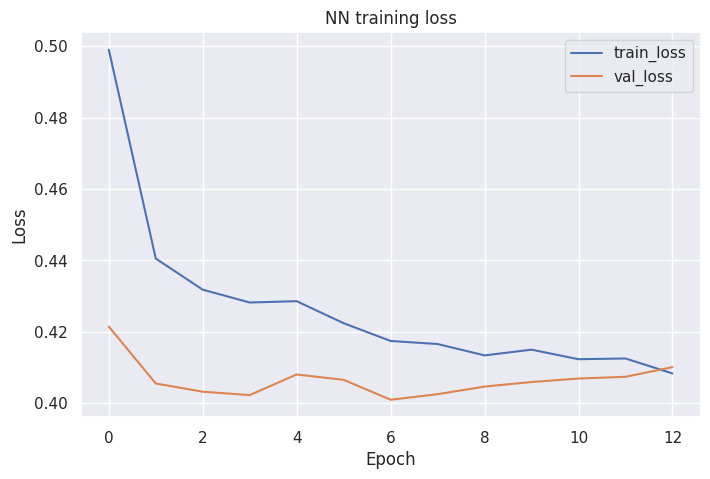

In [44]:
# Train NN with EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = nn_model.fit(
    X_train_proc, y_train.values,
    validation_split=0.15,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

# Plot training curves (loss)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('NN training loss'); plt.legend()
plt.show()

### Evaluate Neural Network and Decision Tree (tuned)
Compute metrics for the final models and prepare a comparison table. Plot ROC curves for both.

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Accuracy,Precision,Recall,F1,AUC
DecisionTree,0.7719,0.5755,0.5401,0.5572,0.7960
NeuralNet,0.7953,0.6433,0.5160,0.5727,0.8357


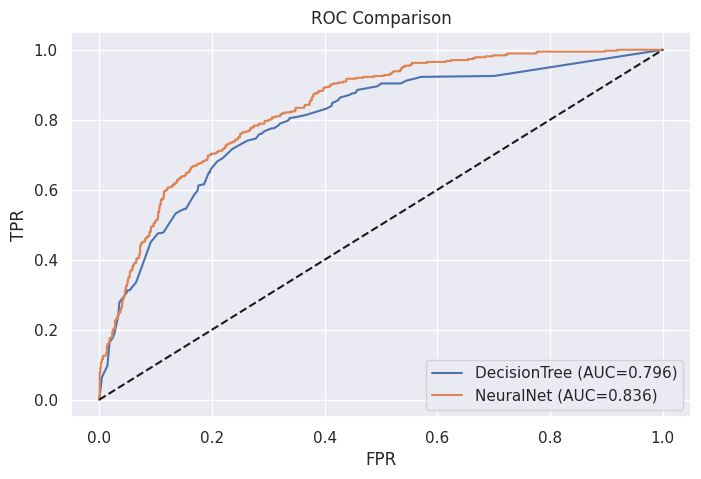

In [45]:
# Evaluate NN and tuned Decision Tree
from sklearn.metrics import roc_curve, auc, confusion_matrix

# NN predictions
nn_probs = nn_model.predict(X_test_proc).ravel()
nn_preds = (nn_probs >= 0.5).astype(int)

# Tuned DT predictions (best_dt from GridSearch)
dt_preds = best_dt.predict(X_test)
dt_probs = best_dt.predict_proba(X_test)[:,1] if hasattr(best_dt.named_steps['clf'], "predict_proba") else None

# Metrics function
def binary_metrics(y_true, y_pred, y_proba=None):
    return {
        'Accuracy': round(accuracy_score(y_true, y_pred),4),
        'Precision': round(precision_score(y_true, y_pred, zero_division=0),4),
        'Recall': round(recall_score(y_true, y_pred, zero_division=0),4),
        'F1': round(f1_score(y_true, y_pred, zero_division=0),4),
        'AUC': round(roc_auc_score(y_true, y_proba),4) if y_proba is not None else None
    }

metrics_dt = binary_metrics(y_test, dt_preds, dt_probs)
metrics_nn = binary_metrics(y_test, nn_preds, nn_probs)

import pandas as pd
res_df = pd.DataFrame([metrics_dt, metrics_nn], index=['DecisionTree','NeuralNet'])
display(res_df)

# ROC curves
plt.figure()
if dt_probs is not None:
    fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)
    plt.plot(fpr_dt, tpr_dt, label=f"DecisionTree (AUC={auc(fpr_dt,tpr_dt):.3f})")
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)
plt.plot(fpr_nn, tpr_nn, label=f"NeuralNet (AUC={auc(fpr_nn,tpr_nn):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Comparison'); plt.legend()
plt.show()

### Save final models
Save the tuned Decision Tree pipeline and Keras model for submission or future use.

In [46]:
# Save models to disk
import joblib, os
os.makedirs('/content/models', exist_ok=True)

# Save sklearn pipeline (best_dt contains preprocessor + clf)
joblib.dump(best_dt, '/content/models/best_dt_pipeline.joblib')
# Save Keras model
nn_model.save('/content/models/nn_model.h5')

print("Saved models to /content/models")

Saved models to /content/models


### Create appendix code file (plain text)
Create a small text file to paste into the report appendix.

In [ ]:
# Create an appendix file placeholder
appendix_path = '/content/appendix_code.txt'
with open(appendix_path, 'w') as f:
    f.write("# Appendix - include full notebook cells here as plain text\n")
    f.write("# Copy/paste important functions and pipeline definitions from your notebook\n")
print("Appendix placeholder saved to", appendix_path)